## Prelude to Hughes & Hase Chapter 8, Part A

Let's start with something familiar: the fitting of 5 data points 
$(x_i, y_i)$ to the linear function $y(x) = mx + b$ to determine 
values for the slope and intercept ($m$ and $b$).  As we have done 
before we will be using the `curve_fit` function from the `optimize` 
sub-module of `scipy`.   

Up to this point we have talked about <i>qualitative</i> assessments of 
whether we should have confidence in the underlying model that we assumed:
+ Are the magnitudes of the normalized residuals around 1? Do the 
error bars for about two-thirds of the normalized residuals include zero?
+ Are there any patterns in the plot of the normalized residuals that
might suggest the assumed functional model needs refinement?
+ Is the  goodness-of-fit parameter $\chi^2_{\text{min}}$ approximately
equal to the number of data points?


In this notebook we will begin the discussion of an another, more quantitative, 
measure, that should be added to the things we consider when answering the question: to 
<b>What confidence can we have in the model?</b>, or equivalently, <b>What 
confidence can we have that we assumed the right function to fit to the data?</b> 

<b>NOTE:</b> There are no new computational tools introduced in this notebook. The 
fitting and plotting is something we have done many times, and simulating data 
sets that are consistent with a model is also something we have done before.  The "new
business" idea here is the use of a histogram of values of $\chi^2$ to draw conclusions
about our confidence in the straight-line model.

Marty Ligare, August 2020

In [1]:
import numpy as np
from scipy import stats
from scipy import optimize

import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
# Following is an Ipython magic command that puts figures in notebook.
%matplotlib notebook
        
# M.L. modifications of matplotlib defaults
# Changes can also be put in matplotlibrc file, 
# or effected using mpl.rcParams[]
mpl.style.use('classic') 
plt.rc('figure', figsize = (6, 4.5)) # Reduces overall size of figures
plt.rc('axes', labelsize=16, titlesize=14)
plt.rc('figure', autolayout = True)  # Adjusts supblot params for new size

#### Functions
Remember:
$$
\chi^2 = \sum_i\frac{\left(y(x_i) - y_i\right)^2}{\alpha_i^2}
$$

In [3]:
def f(x,m,b):
    '''Simple linear function with slope m and intercept b'''
    return m*x + b

def chi2(x, y, u, m, b):
    '''Chisquare as a function of data (x, y, and yerr=u), and model 
    parameters slope and intercept (m and b)'''
    return np.sum((y - f(x, m, b))**2/u**2)

## Data Set I

In [4]:
# Or: data = np.loadtxt("file.dat") 

# Format:  [[x1,y1,u1], [x2,y2,u2], ... ] where u1 is uncertainty in y1
data = np.array([[1, 2.947032612427293, 0.5],
 [2, 6.168779380682309, 0.5],
 [3, 7.1618838821688, 0.5],
 [4, 9.590549514954866, 0.5],
 [5, 11.20657, 0.5]])

x, y, u = data.T

<IPython.core.display.Javascript object>


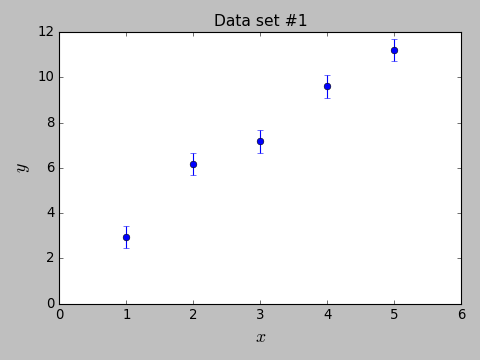

In [5]:
plt.figure()
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Data set #1')
plt.xlim(0,6) 
plt.ylim(0,12)
plt.errorbar(x,y,yerr=u,fmt='o');

### Find best-fit parameters ("old business")

In [6]:
popt, pcov = optimize.curve_fit(f, x, y, sigma=u, absolute_sigma=True)
m_data = popt[0]
alpha_m = np.sqrt(pcov[0,0])  # Std error in slope
b_data = popt[1]
alpha_b = np.sqrt(pcov[1,1])  # Std error in intercept
chi2_data = chi2(x,y,u,*popt)

print("slope =", m_data,"+/-", alpha_m,"\n")
print("intercept =", b_data,"+/-", alpha_b,"\n")
print("chi2 from data =", chi2_data)

slope = 1.994084490943965 +/- 0.15811389158461894 

intercept = 1.4327096052222066 +/- 0.5244044422749461 

chi2 from data = 3.700621429959703


<IPython.core.display.Javascript object>


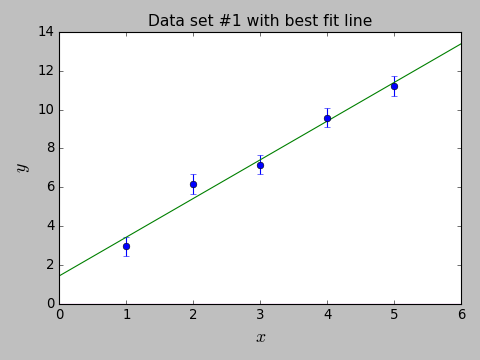

In [7]:
xc = np.linspace(0,6,201) # quasi-continuous set of x's for plot of function
plt.figure()
plt.title("Data set #1 with best fit line",fontsize=14)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.axhline(0, color='magenta')
plt.xlim(0,6)  # Pad x-range on plot
plt.errorbar(x, y, yerr=u, fmt='o');
plt.plot(xc ,f(xc, m_data, b_data));


#### Normalized residuals

<IPython.core.display.Javascript object>


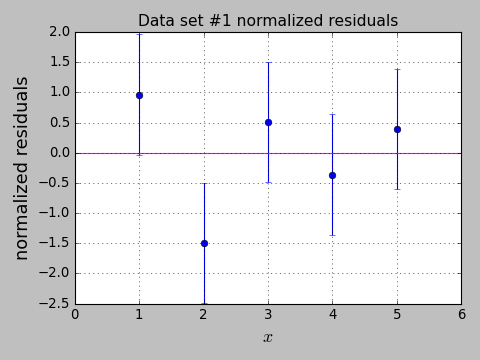

In [8]:
plt.figure()
plt.axhline(0,color='magenta')
plt.title('Data set #1 normalized residuals',fontsize=14)
plt.xlabel('$x$')
plt.ylabel('normalized residuals')
plt.grid(True)
plt.errorbar(x,(f(x,m_data,b_data)-y)/u,1,fmt='o')
plt.xlim(0,6);

### What confidence can we have in the model? ("new business")

The normalized residuals in the figure above look ok according to qualitative assessments 
mentioned, so let's proceed to a more quantitative measure, by looking at the 
consequences of the model.

1. <b>Assume the model is correct</b>, and that any deviations 
from the model are due to the fact that data is the result of
random sampling from normal probability distributions characterized by the 
known standard errors of the data points.  This assumption is called
the <b>null hypothesis</b>.  
2. <b>Generate many simulated data sets</b> based on the model, best-fit parameters, 
and uncertainties. (Use same values for $x_i$.)
3. <b>Fit each of the simulated data sets</b> and store the values of 
$\chi^2$ in an array.
4. <b>Examine the histogram of simulated values of $\chi^2$.</b>
Where does the value of $\chi^2_{\text{min}}$ from the fit to the 
orignal data fall within the histogram?  What's the probability of 
getting values of $\chi^2$ from the simulated data sets 
that are greater than the value given by the data that was actually measured. 
In other words, is our value of $\chi^2$ a reasonable result from the model
and the fluctuations we expect in our data?

#### Simulation

In [9]:
n_sim = 10000         # number of data sets to simulate
count = 0             # counter for keeping track of simulated sets
                      #   that give value of chisq > value from real data
chi2_sim = np.zeros(n_sim) # Array for chisq values from simulated sets

for i in range(n_sim):
    y_sim = stats.norm.rvs(m_data*x + b_data, u)  # Generate simulated data
    popt_sim, pcov_sim = optimize.curve_fit(f, x, y_sim, sigma=u, absolute_sigma=True)
    a = chi2(x,y_sim,u,*popt_sim)    # calculate chisq for simulated data
    chi2_sim[i] = a                  # store value of chisq
    if a > chi2_data:                # increment counter
        count += 1

In [10]:
print("% of simulated sets with chisq larger than that from orig. data =", 100*count/n_sim)
mean  = np.mean(chi2_sim)
sigma = np.sqrt(np.var(chi2_sim))
print("mean of simulated values of chisq =",mean)
print("std of simulated values of chisq=", sigma)

% of simulated sets with chisq larger than that from orig. data = 28.86
mean of simulated values of chisq = 2.9612114609973883
std of simulated values of chisq= 2.4415862554241694


#### Histogram of simulated values of $\chi^2$

<IPython.core.display.Javascript object>


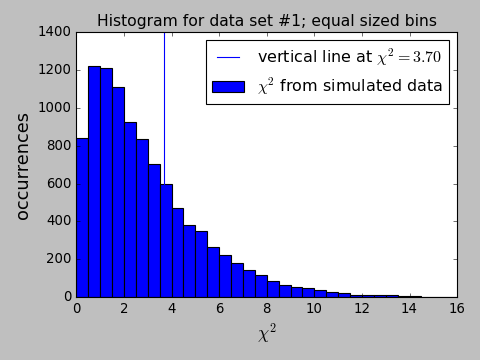

In [11]:
nbins = 32   # Number of bins for histogram
low = 0      # low limit for histogram
#high = mean + 5*sigma
high = 16    # high limit for histrogram

plt.figure()
plt.xlabel("$\chi^2$")
plt.ylabel("occurrences")
plt.title("Histogram for data set #1; equal sized bins")
plt.axvline(chi2_data, label='vertical line at $\chi^2 = 3.70$');
out = plt.hist(chi2_sim, nbins, [low,high], label="$\chi^2$ from simulated data")
#out[0],out[1];   # occurrences and bin boundaries (for use later)
plt.legend();

### Discussion

For a given model (here a linear relationship between $x$ and $y$, along 
with given values of $x_i$ and $\alpha_i$) the histogram gives 
a <i>probability distribution</i> for values of $\chi^2$ that 
minimize data sets consistent with the model and uncertainties.  Notice that 
this is a very asymmetric distribution.

The vertical line is at the value of $\chi^2 = 3.70$ from the fit to the original data.
This value is right in the range of values we should expect from the model. 
To be more quantitative, the simulated data sets indicate that there there is a 29% chance of getting a value of $\chi^2$ that is 3.7 or bigger, so it's not surprising 
that we would get such a value. 
<b>Conclusion: There is no reason to reject the null hypothesis based an 
the observed value of $\chi^2$</b>, i.e., there no reason to reject the linear model.

#### Version Information 
`version_information` is from J.R. Johansson (jrjohansson at gmail.com).
See <a href=http://nbviewer.jupyter.org/github/jrjohansson/scientific-python-lectures/blob/master/Lecture-0-Scientific-Computing-with-Python.ipynb>Introduction to scientific computing with Python</a>
for more information and instructions for package installation.<br>

`version_information` has been installed system-wide on Bucknell linux networked computers. 

In [12]:
%load_ext version_information

In [13]:
version_information numpy, scipy, matplotlib

Software versions
Python 3.7.8 64bit [GCC 7.5.0]
IPython 7.17.0
OS Linux 3.10.0 1062.9.1.el7.x86_64 x86_64 with centos 7.8.2003 Core
numpy 1.19.1
scipy 1.5.0
matplotlib 3.3.0
Fri Aug 21 15:20:59 2020 EDT